In [14]:
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch.nn.functional as F
import numpy as np

In [2]:
def show_image(inp):
    inp = inp / torch.max(inp.view(3, -1), dim=-1).values.view(3, 1, 1)
    inp = torchvision.transforms.ToPILImage()(inp)
    plt.imshow(inp) #[0,...])
    plt.show()

In [3]:
def transform(inp):
    inp = torchvision.transforms.ToTensor()(inp)
    inp = inp + 1e-4
    inp = inp / torch.sum(torch.abs(inp))
    return torch.cat([inp, inp, inp], 0)

In [4]:
MNIST_DIR = "/mnt/home/hlawrence/ceph/datasets" #"/data/theory/robustopt/saachij/dataset_dumps/mnist"

In [5]:
ds = torchvision.datasets.MNIST(MNIST_DIR,
                                train=True, download=False, transform=transform)
dl = torch.utils.data.DataLoader(ds, batch_size=32)
for x, y in dl:
    break

In [136]:

class ConvolutionalWasserstein2D(nn.Module):
    def __init__(self, nin, s, gamma):
        super().__init__()
        self.a = torch.ones(1, nin, s, s) #/(s*s)
        self.s = s
        self.nin = nin
        self.gamma = gamma
        
        g_s = s
        if s % 2 == 0:
            g_s = s+1
        self.H = tgm.image.GaussianBlur((g_s, g_s), (gamma, gamma))
        
        
    def sinkhorn(self, mu_0, mu_1, iters):
        w = torch.ones(*mu_0.shape)
        v = torch.ones(*mu_0.shape)
        for i in range(iters):
            v = mu_0 /(self.H(self.a*w))
            w = mu_1 /(self.H(self.a*v))
        out = mu_0 * torch.log(v) + mu_1 * torch.log(w)
        out = torch.flatten(out, 2, 3).unsqueeze(3)
        a = torch.flatten(out, 2, 3).unsqueeze(2)
        out = (a @ out).squeeze(2).squeeze(2)
        return self.gamma * out
    
    def compute_entropy(self, p):
        # p is (arbitrary batch dim) x nin x H x W
        # returns vector of size (arbitrary batch dim) x nin, or nin, of the separate entropies
        z_locs = (p <= 0)
        if len(p.shape) == 4:
            a_reshaped = self.a
        elif len(p.shape) == 3:
            a_reshaped = self.a[0, ...]
        else:
            a_reshaped = self.a[0, 0, ...]
        prod = a_reshaped * p * torch.log(p) 
        prod[z_locs] = 0
        return -1*torch.sum(prod, dim=[-1, -2])
    
    def entropic_sharpening(self, mu, H0):
        # mu is C x H x W
        # H0 is C 
        C, H, W = mu.shape
        
        # Doing this unbatched in C for now
        betas = torch.ones(C)
        for i in range(C):
            if self.compute_entropy(mu[i,...]) + torch.sum(mu[i, ...]*self.a[0, i, ...]) > H0[i] + 1:
                def f(beta):
                    mu_to_beta = torch.pow(mu[i,...], torch.tensor(beta))
                    return torch.sum(self.a[0, i, ...]*mu_to_beta) + self.compute_entropy(mu_to_beta) - (1 + H0[i])
                xx = fsolve(f, x0=[1]) # Does not include positivity constraint, not ideal.
                if xx[0] >= 0:
                    betas[i] = xx[0]
        sharpened = torch.pow(mu, betas.view(C, 1, 1))
        return sharpened
    
    def wass_barycenter(self, mu_s, alphas, iters, entropic_args=None): # NOT BATCHED
        # mu_s is K x C x H x W
        # alphas is K
        # M is the number of mu_s
        # entropic_args['factor'] changes the level of sharpening by scaling the maximum entropy
        # otherwise, setting entropic_args as None means to not do entropic sharpening
        K, C, H, W = mu_s.shape
        
        if entropic_args is not None:
            H0 = torch.max(self.compute_entropy(mu_s), dim=0).values
            H0 = entropic_args['factor']*H0 
        
        v = torch.ones_like(mu_s)
        w = torch.ones_like(mu_s)
        for j in range(iters):
            w = mu_s / self.H(self.a * v)
            d = v * self.H(self.a * w)
            mu = torch.ones(C, H, W)
            for i in range(K):
                mu = mu * torch.pow(d[i], alphas[i])
            if entropic_args is not None:
                mu = self.entropic_sharpening(mu, H0)
            v = (v * mu.unsqueeze(0))/d
        return mu
    
    def wass_barycenter_obj(self, mu, mu_s, alphas):
        # mu_s is K x C x H x W
        # alphas is K
        # mu is C x H x W
        K, C, H, W = mu_s.shape
        
        mu_repped = mu.repeat(K, 1, 1, 1)
        W2dists = self.sinkhorn(mu_repped, mu_s, iters=10) # K x C
        objvals = W2dists * alphas.view(-1,1).repeat_interleave(repeats=C, dim=-1) # K x C
        return torch.sum(objvals, 0)
    

inp torch.Size([2, 3, 28, 28])


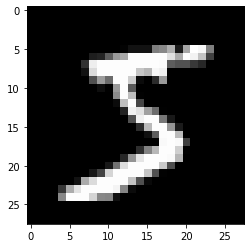

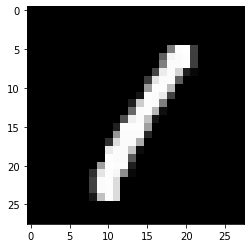

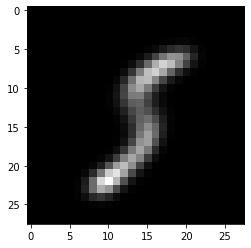

Barycenter objective value:  tensor(1.6156)


In [137]:
# example conv_was
cw = ConvolutionalWasserstein2D(3, 28, gamma=2)
with torch.no_grad():
    inp = x[[0, 3]]
    print('inp', inp.shape)
    alphas = torch.tensor([0.5, 0.5])
    facs = [0.3] #[5,6,7,8,9,10]
    for fac in facs:
        out = cw.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
        show_image(inp[0, ...])
        show_image(inp[1, ...])
        show_image(out)

objval = cw.wass_barycenter_obj(out, inp, alphas)
print('Barycenter objective value: ',objval[0])

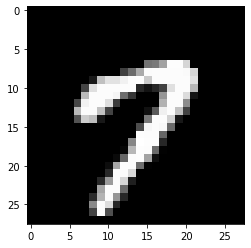

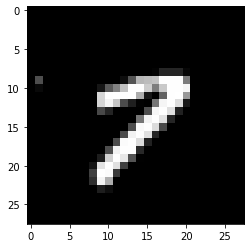

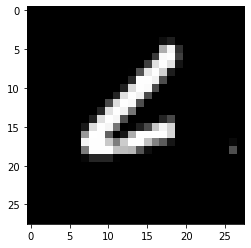

Comparison of Wasserstein barycenter objective, for different rotations
Correct: tensor(0.3056) Rot. 90:  tensor(0.4490) Rot. 180:  tensor(0.3866) Rot. 270:  tensor(0.4243)


In [138]:
# Is Wasserstein distance a good alignment metric? Test this first without doing any fancy rotations
# Consider two sevens: asymmetric
# print(torch.where(y == 7))
seven1 = x[15, ...]
seven2 = x[29, ...]
show_image(x[15, ...])
show_image(x[29, ...]) # note: this one is small enough that can probably rotate continuously??
show_image(seven2.flip(-1).flip(-2))
objvals=cw.sinkhorn(seven1, seven2, iters=10)
objvals90=cw.sinkhorn(seven1, torch.rot90(seven2, k=1, dims=[1,2]), iters=10)
objvals180=cw.sinkhorn(seven1, seven2.flip(-1).flip(-2), iters=10)
objvals270=cw.sinkhorn(seven1, torch.rot90(seven2, k=-1, dims=[1,2]), iters=10)
print('Comparison of Wasserstein barycenter objective, for different rotations')
print('Correct:', objvals[0, 0], 'Rot. 90: ', objvals90[0, 0], 'Rot. 180: ', objvals180[0, 0], 'Rot. 270: ', objvals270[0, 0])

In [139]:
# From stack overflow https://stackoverflow.com/questions/64197754/how-do-i-rotate-a-pytorch-image-tensor-around-its-center-in-a-way-that-supports
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x

def rot_and_renorm(img, theta):
    # img is B x C x H x W
    B, C, H, W = img.shape
    out = rot_img(img, theta, img.dtype)
    # fill in values, under assumption that upper left corner is representative
    out[out < 1e-8] = img[0, 0, 0, 0]
    out = out / (torch.sum(out, dim=[-1, -2]).view(B, C, 1, 1).repeat(1, 1, H, W))
    return out

def wrap_around_angle(angles1, angles2):
    # either both scalars, or both of length B
    # between 0 and 2*pi
    diffs = torch.abs(torch.tensor(angles1 - angles2))
    dists = torch.min(diffs, torch.remainder(-1*diffs, 2*np.pi))
    return dists
    
out=rot_img(seven1.float().view(1, 3,28,28), 0.5*(np.pi/2), seven1.float().dtype)

/mnt/home/hlawrence/miniconda3/envs/cryo/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/mnt/home/hlawrence/miniconda3/envs/cryo/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Eights


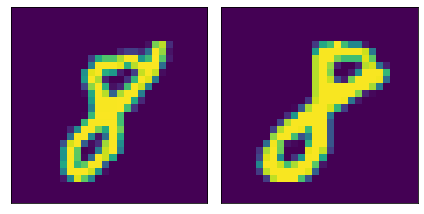

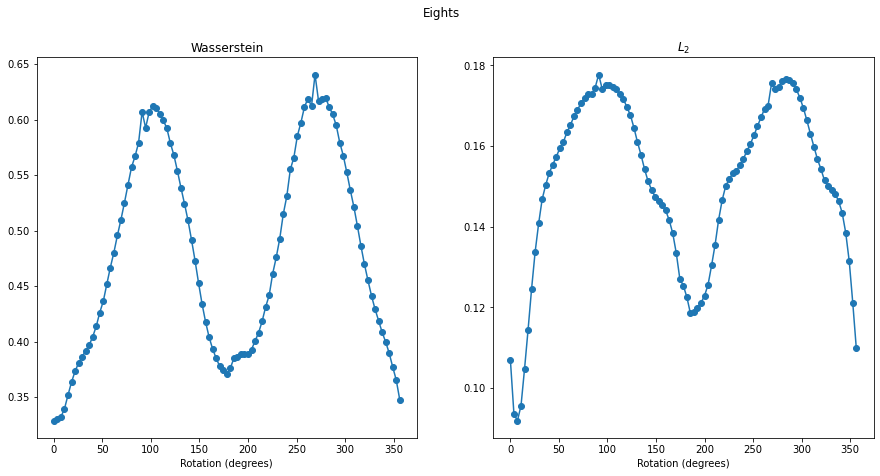

Sevens


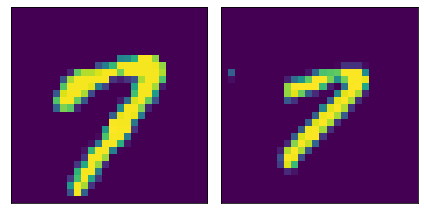

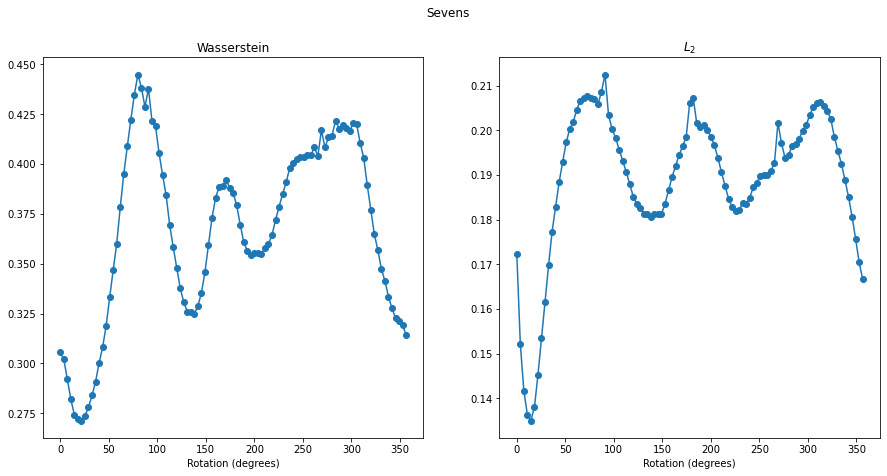

Eight, W2 err: tensor(0.)
Eight, L2 err: tensor(0.1269)
Seven, W2 err: tensor(0.3808)
Seven, L2 err: tensor(0.2539)


In [149]:
# L2 vs W2 distance for particular examples (7s and 5s) of image pairs
numtheta = 100
iters = 10
thetas = 2*np.pi*np.linspace(0,1,numtheta); thetas = thetas[0:-1]
#print(torch.where(y == 8))
seven1 = x[15, ...] # 15 for 7
seven2 = x[29, ...] # 29 for 7, 19 for 9
eight1 = x[17, ...] # 17 for 8
eight2 = x[31, ...] # 31 for 8
sevens_W2 = torch.zeros(len(thetas))
eights_W2 = torch.zeros(len(thetas))
sevens_L2 = torch.zeros(len(thetas))
eights_L2 = torch.zeros(len(thetas))
for ind, theta in enumerate(thetas):
    roteight2 = rot_and_renorm(eight2.unsqueeze(0), theta)
    rotseven2 = rot_and_renorm(seven2.unsqueeze(0), theta)
    eights_W2[ind] = cw.sinkhorn(eight1, roteight2, iters=iters)[0, 0]
    sevens_W2[ind] = cw.sinkhorn(seven1, rotseven2, iters=iters)[0, 0]
    eights_L2[ind] = torch.norm(eight1 - roteight2)
    sevens_L2[ind] = torch.norm(seven1 - rotseven2)

print('Eights')
plt.figure()
plt.subplot(121)
plt.imshow(eight1[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.subplot(122)
plt.imshow(eight2[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(thetas / (2*np.pi) * 360, eights_W2,'o-')
plt.xlabel('Rotation (degrees)')
plt.title('Wasserstein')
plt.subplot(122)
plt.plot(thetas / (2*np.pi) * 360, eights_L2,'o-')
plt.title(r'$L_2$')
plt.xlabel('Rotation (degrees)')
plt.suptitle('Eights')
plt.show()

print('Sevens')
plt.figure()
plt.subplot(121)
plt.imshow(seven1[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.subplot(122)
plt.imshow(seven2[0,...])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(thetas / (2*np.pi) * 360, sevens_W2,'o-')
plt.title('Wasserstein')
plt.xlabel('Rotation (degrees)')
plt.subplot(122)
plt.plot(thetas / (2*np.pi) * 360, sevens_L2,'o-')
plt.title(r'$L_2$')
plt.xlabel('Rotation (degrees)')
plt.suptitle('Sevens')
plt.show()
    
print('Eight, W2 err:', wrap_around_angle(thetas[torch.argmin(eights_W2)], 0))
print('Eight, L2 err:', wrap_around_angle(thetas[torch.argmin(eights_L2)], 0))
print('Seven, W2 err:', wrap_around_angle(thetas[torch.argmin(sevens_W2)], 0))
print('Seven, L2 err:', wrap_around_angle(thetas[torch.argmin(sevens_L2)], 0))

Aligned Barycenters


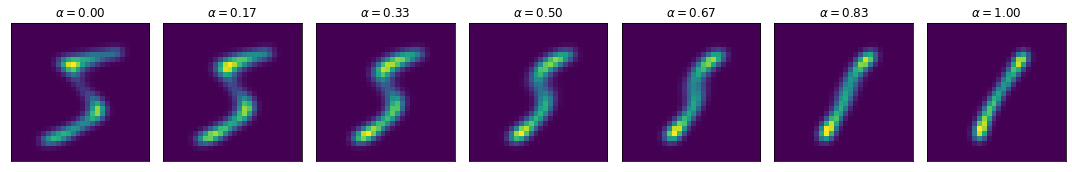

Unaligned Barycenters


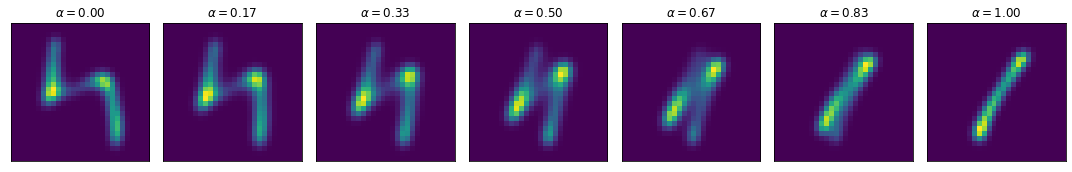

In [135]:
# Next figure: rotated vs unrotated barycenters
ops = [False, True]
for do_rot in ops:
    if do_rot:
        print('Unaligned Barycenters')
    else:
        print('Aligned Barycenters')
    im1 = x[3, ...]
    im2 = x[0, ...]
    if do_rot:
        im2 = rot_and_renorm(im2.unsqueeze(0), np.pi * 0.4)[0, ...]
    numalpha = 7
    alphas = np.linspace(0, 1, numalpha) # barycenter code isn't batched in alpha, have to loop it for now
    plt.figure(figsize=(15, 10))
    for ind, alpha in enumerate(alphas):
        plt.subplot(1, numalpha, ind+1)
        out = cw.wass_barycenter(torch.stack((im1, im2), dim=0), torch.tensor([alpha, 1-alpha]), 10, entropic_args={'factor':0.3})
        plt.imshow(out[0,...])
        plt.title(r'$\alpha = ${:.2f}'.format(alpha))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()
    

In [151]:
print(torch.where(y == 2))

(tensor([ 5, 16, 25, 28]),)
